# Process NDVI images and plot
This script loads NDVI images (tifs) created from *CreateNDVI.ipyb*

In [1]:
# Import packages
from osgeo import gdal
import os
import glob

import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatabl
import numpy as np
import rasterio
import xarray
import rioxarray
import datetime

In [2]:
# Define filepaths
filepath7 = 'E:/GitHub/GEOG_L7/'
filepath8 = 'E:/GitHub/GEOG_L8/'

filepath_DF_mask = 'E:/GitHub/PostFire_NDVI/DouglasFireTiffs/DF_area.tif'
filepath_DF_ownership = 'E:/GitHub/PostFire_NDVI/DouglasFireTiffs/DF_ownership.tif'

# create rasters from DF_area.tif and DF_ownership
df_mask = rioxarray.open_rasterio(filepath_DF_mask)
df_ownership = rioxarray.open_rasterio(filepath_DF_ownership)

# Define list of Landsat bands
files7 = sorted(glob.glob(filepath7 + '*.tif'))
files8 = sorted(glob.glob(filepath8 + '*.tif'))

In [3]:
def create_timeseries(files):
    times = []
    for name in files:
        times.append(name.split("_")[-1].split(".")[0])
        
    dates = []    
    for date in times:
        # format
        format = '%Y%m%d'

        # convert from string format to datetime format
        datetime_var = datetime.datetime.strptime(date, format)

        # get the date from the datetime using date()
        dates.append(datetime_var.date())
    return dates
        

def analyze_ownership(file):
    ndvi = rioxarray.open_rasterio(file)
    t = ndvi.squeeze(drop=True, axis=0)
    
    # 1 = private, 0 = BLM
    private_ndvi = ndvi.where(df_ownership == 1)
    private_ndvi = private_ndvi.squeeze(drop=True, axis=0)
    
    blm_ndvi = ndvi.where(df_ownership == 0)
    blm_ndvi = blm_ndvi.squeeze(drop=True, axis=0)
    
    return private_ndvi.values.flatten(), blm_ndvi.values.flatten()

In [4]:
filepath_ndvi = "E:/GitHub/landsat_ndvi/"
files_ndvi = sorted(glob.glob(filepath_ndvi + '*.tif'))

times = create_timeseries(files_ndvi)
times.sort()

### flatten tiffs

In [5]:
ownership_flattened_priv = []
ownership_flattened_blm = []

for file in files_ndvi:
    priv, blm = analyze_ownership(file)
    ownership_flattened_priv.append(priv)
    ownership_flattened_blm.append(blm)
    
for ii in range(len(ownership_flattened_priv)):
    ownership_flattened_priv[ii] = ownership_flattened_priv[ii][~np.isnan(ownership_flattened_priv[ii])]
for ii in range(len(ownership_flattened_blm)):
    ownership_flattened_blm[ii] = ownership_flattened_blm[ii][~np.isnan(ownership_flattened_blm[ii])]
    

# Plotting of Figures

## Pre and post-fire NDVI images

In [25]:
times

[datetime.date(2011, 8, 23),
 datetime.date(2011, 9, 8),
 datetime.date(2011, 9, 24),
 datetime.date(2011, 10, 26),
 datetime.date(2011, 11, 11),
 datetime.date(2011, 12, 13),
 datetime.date(2012, 2, 15),
 datetime.date(2012, 5, 5),
 datetime.date(2012, 6, 6),
 datetime.date(2012, 7, 8),
 datetime.date(2012, 7, 24),
 datetime.date(2012, 8, 25),
 datetime.date(2012, 9, 26),
 datetime.date(2013, 1, 16),
 datetime.date(2013, 4, 30),
 datetime.date(2013, 6, 1),
 datetime.date(2013, 6, 17),
 datetime.date(2013, 7, 3),
 datetime.date(2013, 7, 19),
 datetime.date(2013, 8, 4),
 datetime.date(2013, 8, 20),
 datetime.date(2013, 10, 23),
 datetime.date(2013, 11, 24),
 datetime.date(2013, 12, 26),
 datetime.date(2014, 6, 4),
 datetime.date(2014, 7, 6),
 datetime.date(2014, 8, 7),
 datetime.date(2014, 8, 23),
 datetime.date(2014, 9, 8),
 datetime.date(2014, 11, 11),
 datetime.date(2015, 1, 30),
 datetime.date(2015, 4, 20),
 datetime.date(2015, 6, 7),
 datetime.date(2015, 8, 26),
 datetime.date(2015

In [42]:
NDVIexample_prefire = rasterio.open(files_ndvi[times.index(datetime.date(2011, 8, 23))])
NDVIexample_midfire = rasterio.open(files_ndvi[times.index(datetime.date(2013, 8, 4))])
NDVIexample_postfire = rasterio.open(files_ndvi[times.index(datetime.date(2021, 8,10 ))])

plt.rcParams['pdf.fonttype'] = 42

plt.rcParams['ps.fonttype'] = 42

In [43]:
# Plot Three Time Steps Together
#fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True, figsize=(40, 30))
# #fig.suptitle("NDVI from three time steps")
# ax1.imshow(NDVIexample_prefire.read(1), cmap = 'turbo')
# ax1.set_title('Pre-fire')
# ax2.imshow(NDVIexample_midfire.read(1), cmap = 'turbo')
# ax2.set_title('mid-fire')
# ax3.imshow(NDVIexample_postfire.read(1), cmap = 'turbo')
# ax3.set_title('Present')

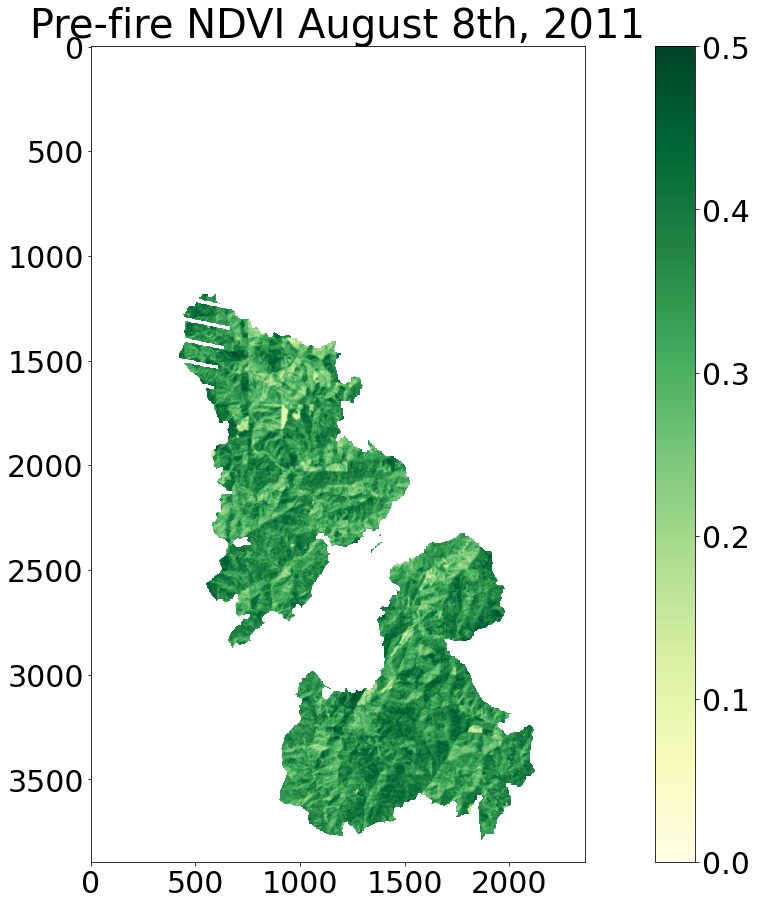

In [44]:
# Plot Pre-fire Date (in July)
fig = plt.figure(figsize = (25,15))
plt.imshow(NDVIexample_prefire.read(1), cmap = 'YlGn',vmin=0, vmax=0.5)
plt.xticks(fontsize= 30)
plt.yticks(fontsize= 30)
plt.title("Pre-fire NDVI August 8th, 2011", fontsize = 40)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30) 
plt.savefig('E:/GitHub/PostFire_NDVI/Figures_python/NDVI_prefire.png')
plt.savefig('E:/GitHub/PostFire_NDVI/Figures_python/NDVI_prefire.pdf')


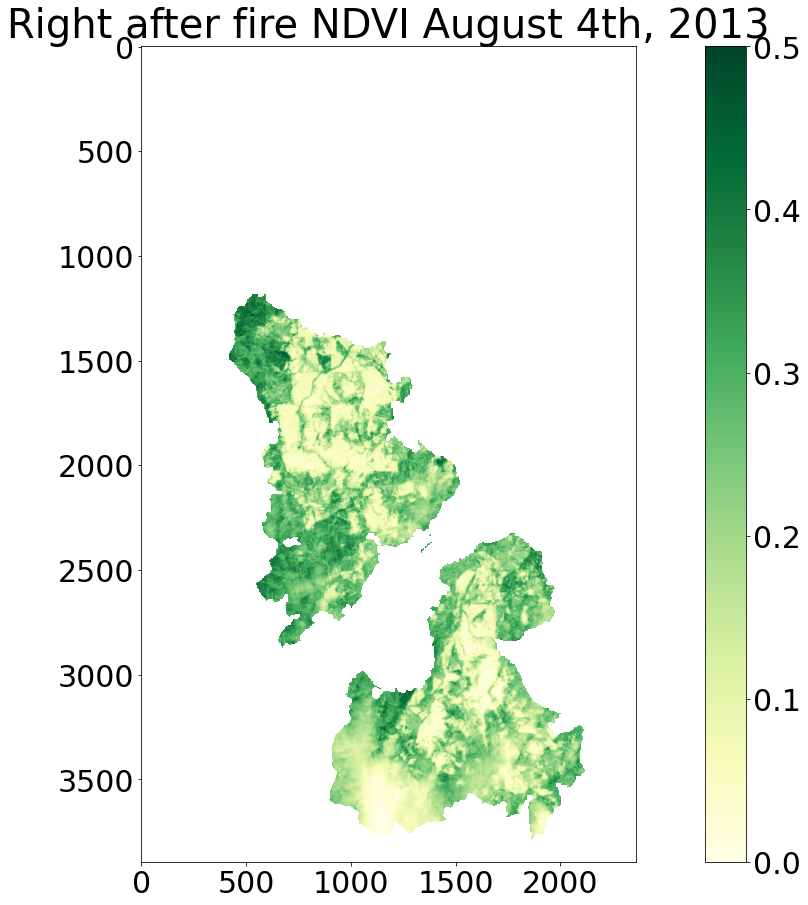

In [45]:
# Plot right after the fire (in July)
# Plot Pre-fire Date (in July)
fig = plt.figure(figsize = (25,15))
plt.imshow(NDVIexample_midfire.read(1), cmap = 'YlGn',vmin=0, vmax=0.5)
plt.xticks(fontsize= 30)
plt.yticks(fontsize= 30)
plt.title("Right after fire NDVI August 4th, 2013", fontsize = 40)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30) 
plt.savefig('E:/GitHub/PostFire_NDVI/Figures_python/NDVI_midfire.png')
plt.savefig('E:/GitHub/PostFire_NDVI/Figures_python/NDVI_midfire.pdf')

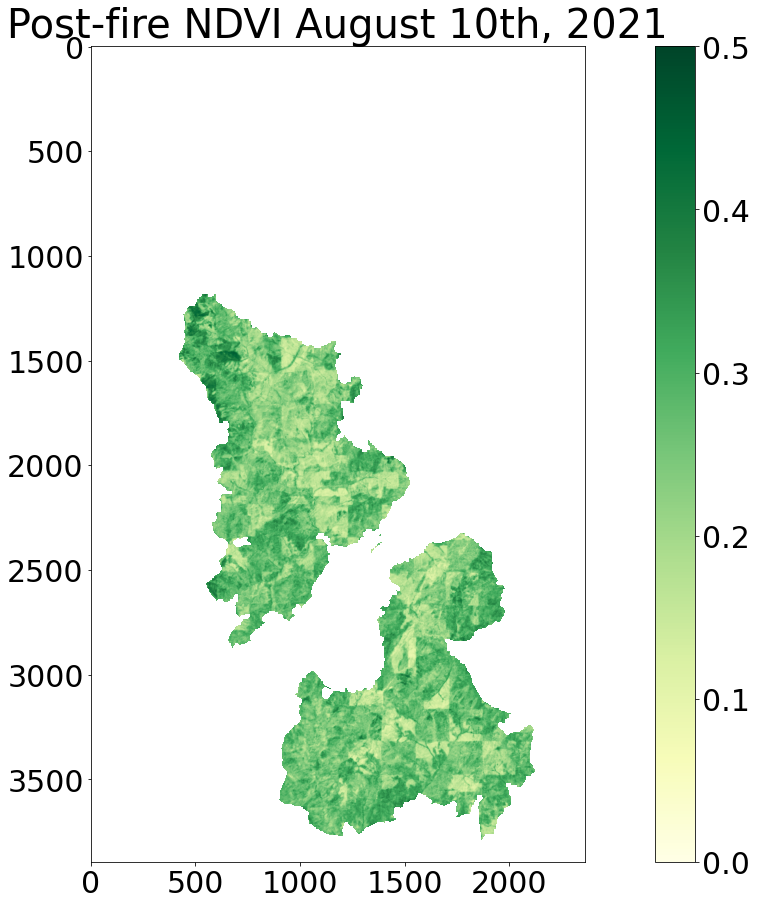

In [47]:
# Plot more recent date (in July)
# Plot Pre-fire Date (in July)
fig = plt.figure(figsize = (25,15))
plt.imshow(NDVIexample_postfire.read(1), cmap = 'YlGn',vmin=0, vmax=0.5)
plt.xticks(fontsize= 30)
plt.yticks(fontsize= 30)
plt.title("Post-fire NDVI August 10th, 2021", fontsize = 40)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30) 
plt.savefig('E:/GitHub/PostFire_NDVI/Figures_python/NDVI_curfire.png')
plt.savefig('E:/GitHub/PostFire_NDVI/Figures_python/NDVI_curfire.pdf')

In [15]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

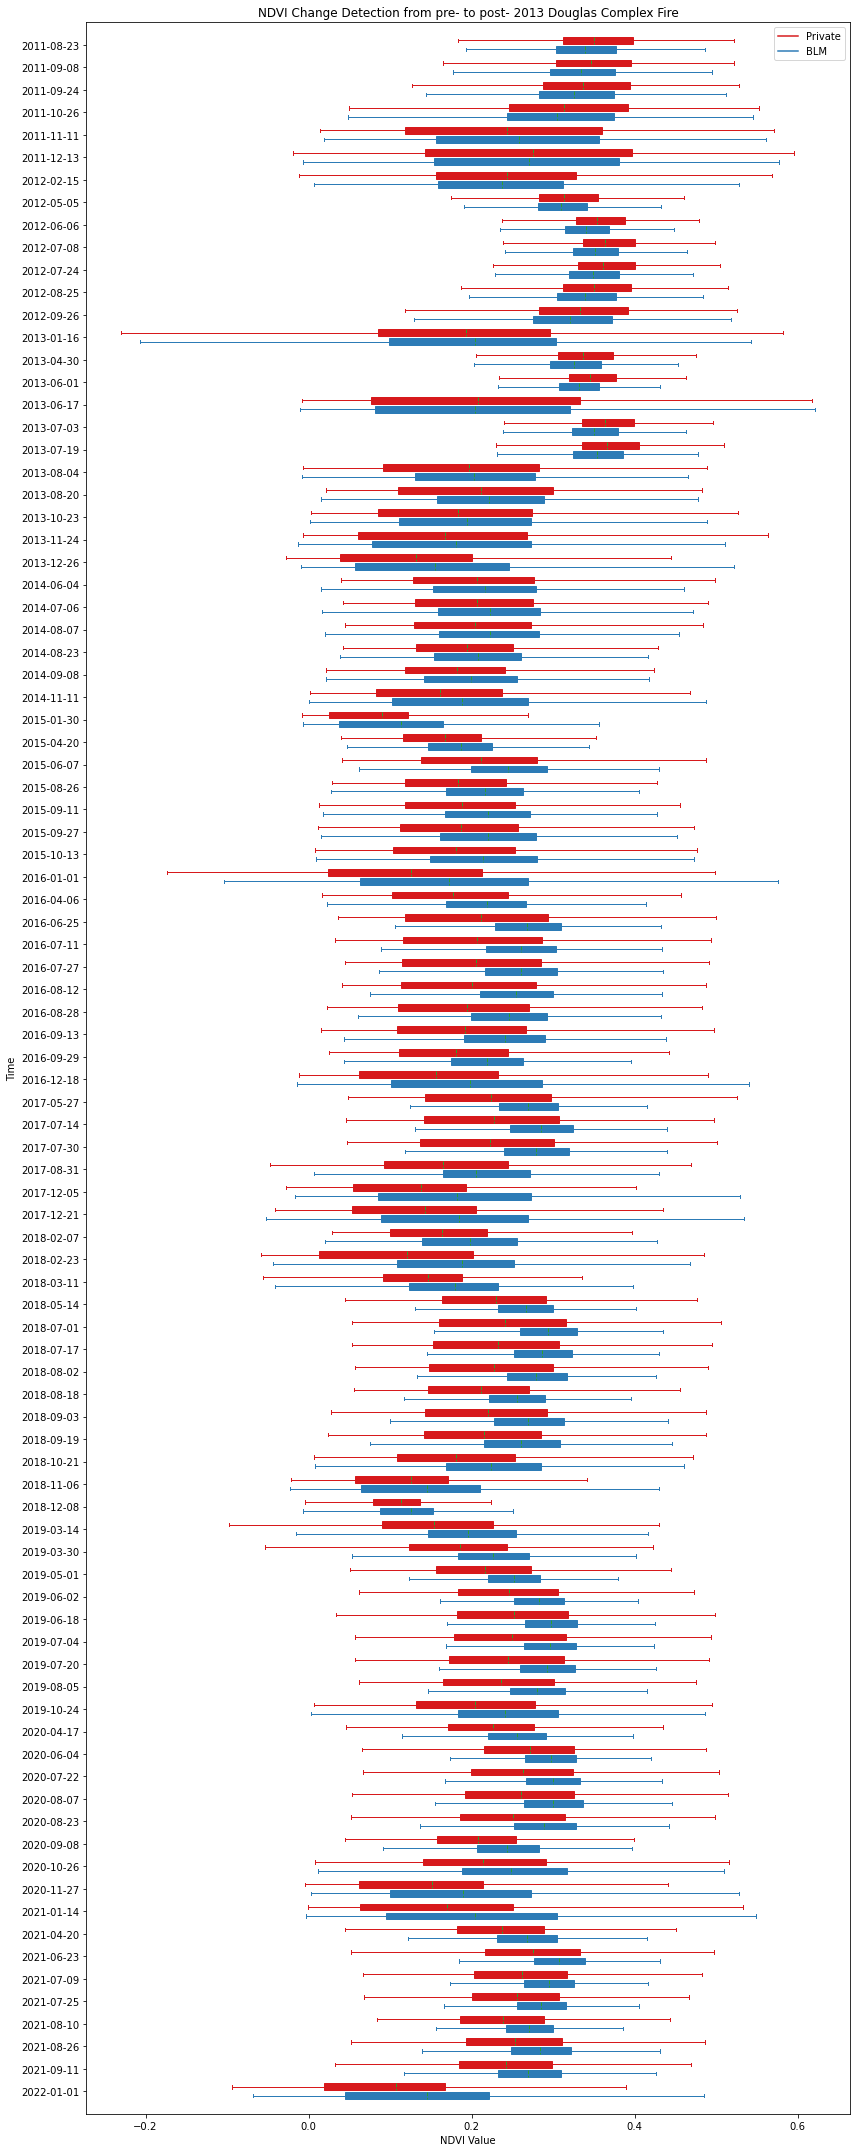

In [16]:
plt.figure(figsize=(12, 30))

# vert = 0 for vertical boxplot, also switch y and x options
bppriv = plt.boxplot(ownership_flattened_priv, positions=np.array(range(len(ownership_flattened_priv)))*2.0-0.4, sym='', widths=0.6, vert = 0, showmeans=True, meanline=True,patch_artist=True)
bpblm = plt.boxplot(ownership_flattened_blm, positions=np.array(range(len(ownership_flattened_blm)))*2.0+0.4, sym='', widths=0.6, vert = 0, showmeans=True, meanline=True,patch_artist=True)
set_box_color(bppriv, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpblm, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private')
plt.plot([], c='#2C7BB6', label='BLM')
plt.legend()

plt.yticks(range(0, len(times) * 2, 2), times)
plt.ylim(len(times)*2,-2)
plt.ylabel('Time')
plt.xlabel('NDVI Value')
plt.title('NDVI Change Detection from pre- to post- 2013 Douglas Complex Fire')
plt.tight_layout()

plt.savefig('E:/GitHub/PostFire_NDVI/Figures_python/NDVI_time_all.png')
plt.savefig('E:/GitHub/PostFire_NDVI/Figures_python/NDVI_time_all.pdf')

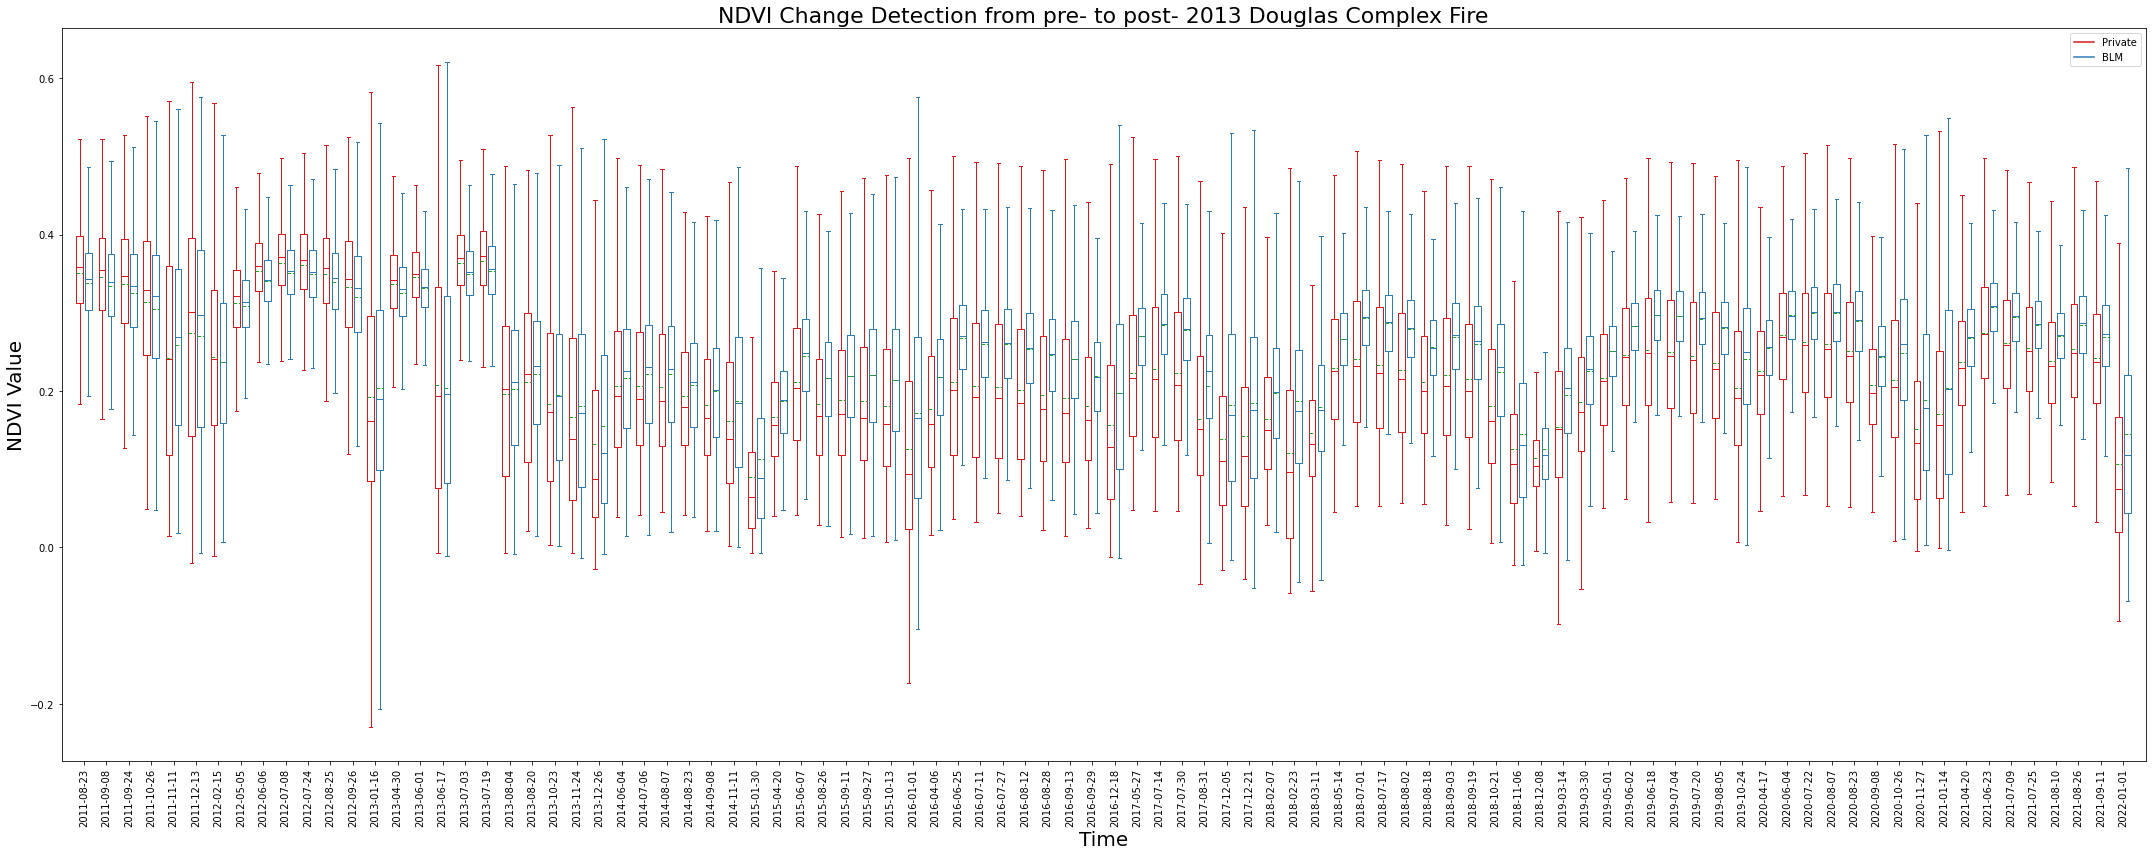

In [17]:
plt.figure(figsize=(30, 12))

bppriv = plt.boxplot(ownership_flattened_priv, positions=np.array(range(len(ownership_flattened_priv)))*2.0-0.4, sym='', widths=0.6, showmeans=True, meanline=True)
bpblm = plt.boxplot(ownership_flattened_blm, positions=np.array(range(len(ownership_flattened_blm)))*2.0+0.4, sym='', widths=0.6, showmeans=True, meanline=True)
set_box_color(bppriv, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpblm, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private')
plt.plot([], c='#2C7BB6', label='BLM')
plt.legend()

plt.xticks(range(0, len(times) * 2, 2), times)
plt.xlim(-2,len(times)*2)
plt.xticks(rotation=90)
plt.xlabel('Time', fontsize=20)
plt.ylabel('NDVI Value', fontsize=20)
plt.title('NDVI Change Detection from pre- to post- 2013 Douglas Complex Fire', fontsize=22)
plt.tight_layout()
#plt.savefig('boxcompare_horz.svg')

In [18]:
#currently subscripted for horizontal boxplots. Change first subscript from 1 -> 0 to do vertical
means_priv = [list(item.get_data()[1])[0] for item in bppriv['means']]
means_blm = [list(item.get_data()[1])[0] for item in bpblm['means']]

# q1_priv = [list(item.get_data()[1])[0] for item in bppriv['boxes']]
# q3_priv = [list(item.get_data()[1])[2] for item in bppriv['boxes']]
# q1_blm = [list(item.get_data()[1])[0] for item in bpblm['boxes']]
# q3_blm = [list(item.get_data()[1])[2] for item in bpblm['boxes']]

std_priv = [np.std(list(item)) for item in ownership_flattened_priv]
std_blm = [np.std(list(item)) for item in ownership_flattened_blm]

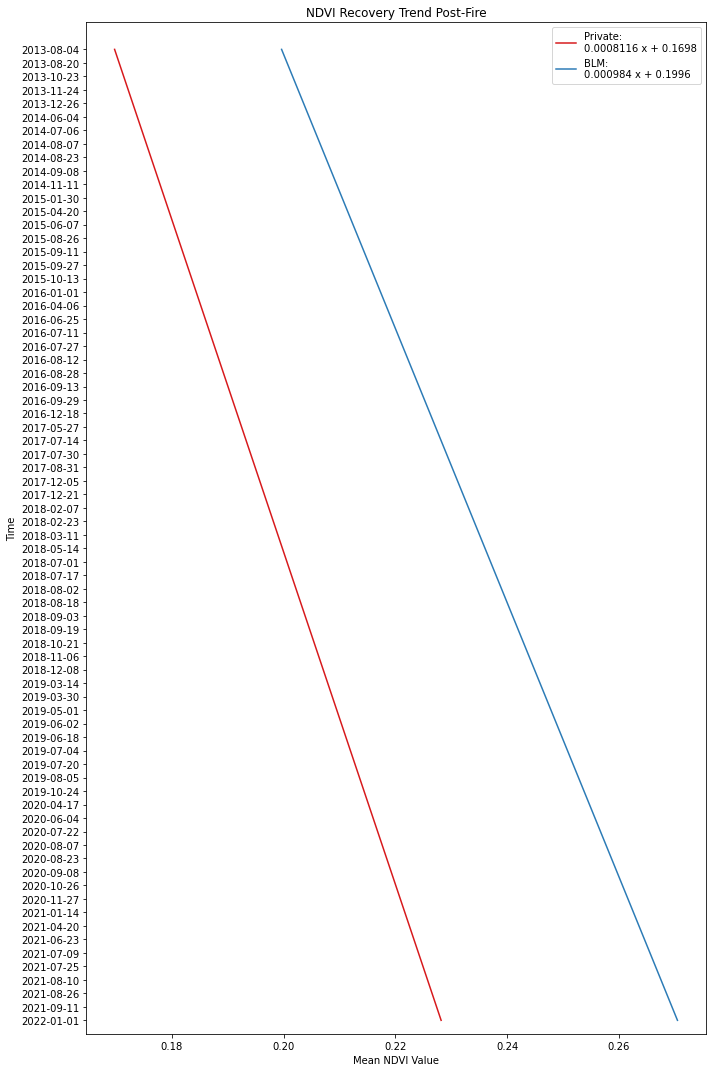

In [19]:
plt.figure(figsize=(10, 15))

x = np.arange(0, len(times[19:]))

z1 = np.polyfit(x, means_priv[19:], 1)
p1 = np.poly1d(z1)
plt.plot(p1(x), x, c='#D7191C')
         
z2 = np.polyfit(x, means_blm[19:], 1)
p2 = np.poly1d(z2)
plt.plot(p2(x), x, c='#2C7BB6')


# zq1priv = np.polyfit(x, q1_priv[19:], 1)
# pq1priv = np.poly1d(zq1priv)
         
# zq3priv = np.polyfit(x, q3_priv[19:], 1)
# pq3priv = np.poly1d(zq3priv)

# zq1blm = np.polyfit(x, q1_blm[19:], 1)
# pq1blm = np.poly1d(zq1blm)
         
# zq3blm = np.polyfit(x, q3_blm[19:], 1)
# pq3blm = np.poly1d(zq3blm)

#plt.fill_between(x, pq1priv(x), pq3priv(x), color='#D7191C', alpha=0.2)
#plt.fill_between(x, pq1blm(x), pq3blm(x), color='#2C7BB6', alpha=0.2)


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private: %s' %(str(p1)))
plt.plot([], c='#2C7BB6', label='BLM: %s' %(str(p2)))
plt.legend()

plt.yticks(x, times[19:]);
plt.ylim(len(times[19:]),-2);
plt.ylabel('Time')
plt.xlabel('Mean NDVI Value')
plt.title('NDVI Recovery Trend Post-Fire')
plt.tight_layout()
#plt.savefig('boxcompare_horz.svg')

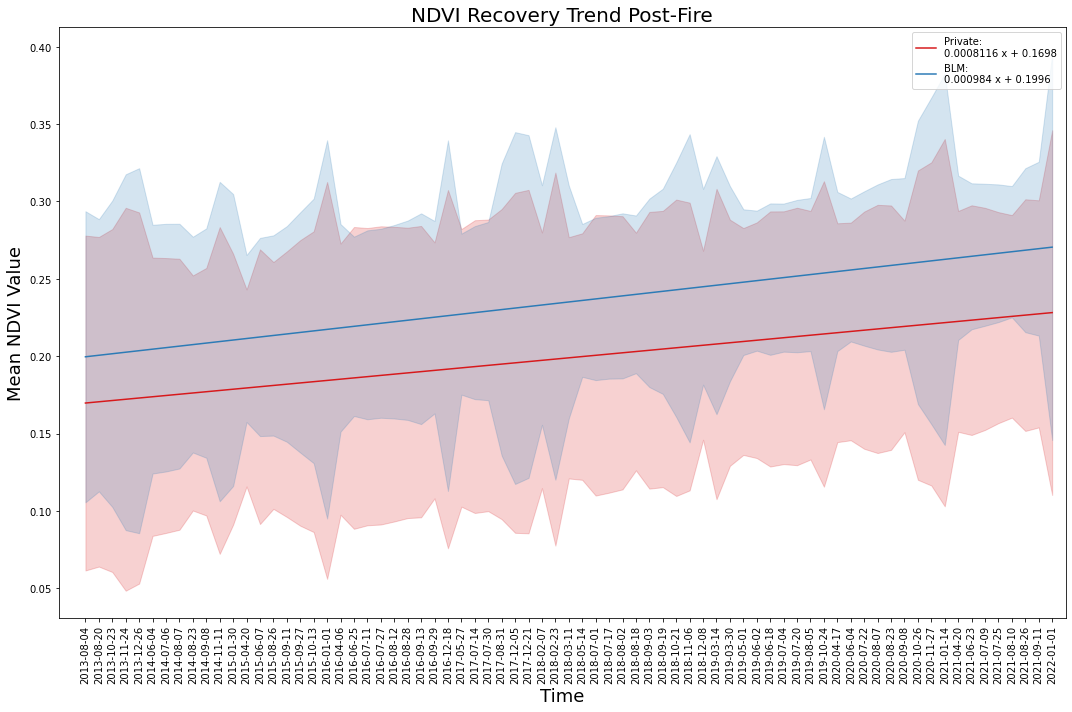

In [20]:
plt.figure(figsize=(15, 10))

x = np.arange(0, len(times[19:]))

z1 = np.polyfit(x, means_priv[19:], 1)
p1 = np.poly1d(z1)
plt.plot(x, p1(x), c='#D7191C')
         
z2 = np.polyfit(x, means_blm[19:], 1)
p2 = np.poly1d(z2)
plt.plot(x, p2(x), c='#2C7BB6')

# zq1priv = np.polyfit(x, q1_priv[19:], 1)
# pq1priv = np.poly1d(zq1priv)
         
# zq3priv = np.polyfit(x, q3_priv[19:], 1)
# pq3priv = np.poly1d(zq3priv)

# zq1blm = np.polyfit(x, q1_blm[19:], 1)
# pq1blm = np.poly1d(zq1blm)
         
# zq3blm = np.polyfit(x, q3_blm[19:], 1)
# pq3blm = np.poly1d(zq3blm)

# plt.fill_between(x, pq1priv(x), pq3priv(x), color='#D7191C', alpha=0.2)
# plt.fill_between(x, pq1blm(x), pq3blm(x), color='#2C7BB6', alpha=0.2)

plt.fill_between(x, p1(x)-std_priv[19:], p1(x)+std_priv[19:], color='#D7191C', alpha=0.2)
plt.fill_between(x, p2(x)-std_blm[19:], p2(x)+std_blm[19:], color='#2C7BB6', alpha=0.2)

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private: %s' %(str(p1)))
plt.plot([], c='#2C7BB6', label='BLM: %s' %(str(p2)))
plt.legend()

plt.xticks(x, times[19:]);
plt.xlim(-2,len(times[19:]));
plt.xticks(rotation=90)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Mean NDVI Value', fontsize=18)
plt.title('NDVI Recovery Trend Post-Fire', fontsize=20)
plt.tight_layout()
plt.savefig('trendlines_horz.svg')

In [80]:
timesno2012 = []
for day in times:
    if day.year > 2012:
        timesno2012.append(day)

In [71]:
July = [] #JuneJulyAugust = []
PrivJJ = []
BLMJJ = []
indJJ = []
for day in timesno2012:
    #print(day)
    if day.month in [7]: 
        July.append(day)
        PrivJJ.append(ownership_flattened_priv[times.index(datetime.date(day.year, day.month, day.day))])
        BLMJJ.append(ownership_flattened_blm[times.index(datetime.date(day.year, day.month, day.day))])
        indJJ.append(times.index(datetime.date(day.year, day.month, day.day)))
        
startSetP = 0.5*(PrivJJ[July.index(datetime.date(2013, 7, 19))] +  PrivJJ[July.index(datetime.date(2013, 7, 3))])
startSetB = 0.5*(BLMJJ[July.index(datetime.date(2013, 7, 19))] + BLMJJ[July.index(datetime.date(2013, 7, 3))])

In [76]:
dndvi_priv = []
dndvi_blm = []
for ts in PrivJJ:
#     print(len(ts))
#     print(len(startSetP))
    if len(ts) == len(startSetP):
        #print(len(ts))
        dndvi_ts = np.divide((startSetP - ts),startSetP)*100 #(startSetP - ts)*1000 #
        dndvi_priv.append(dndvi_ts)
    
for ts in BLMJJ:
    if len(ts) == len(startSetB):
        #print(len(ts))
        dndvi_ts = np.divide((startSetB- ts),startSetB)*100 #(startSetB - ts)*1000 #
        dndvi_blm.append(dndvi_ts)

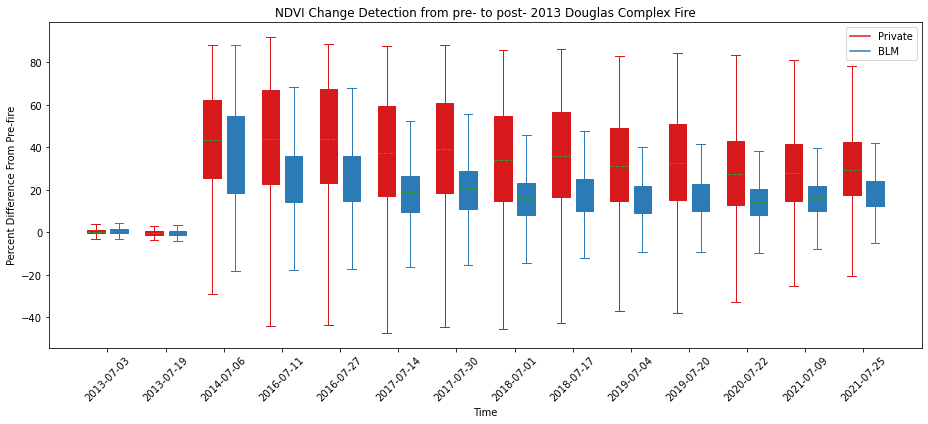

In [82]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(13, 6))

# vert = 0 for vertical boxplot, also switch y and x options
bppriv = plt.boxplot(dndvi_priv, positions=np.array(range(len(dndvi_priv)))*2.0-0.4, sym='', widths=0.6, showmeans=True, meanline=True,patch_artist=True)
bpblm = plt.boxplot(dndvi_blm, positions=np.array(range(len(dndvi_blm)))*2.0+0.4, sym='', widths=0.6, showmeans=True, meanline=True,patch_artist=True)
set_box_color(bppriv, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpblm, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private')
plt.plot([], c='#2C7BB6', label='BLM')
plt.legend()

plt.xticks(range(0, len(July) * 2, 2), July, rotation = 45)
plt.xlim(-2,len(July)*2)
plt.xlabel('Time')
plt.ylabel('Percent Difference From Pre-fire')
plt.title('NDVI Change Detection from pre- to post- 2013 Douglas Complex Fire')
plt.tight_layout()

plt.savefig('E:/GitHub/PostFire_NDVI/Figures_python/NDVI_percdiff_July.png')
plt.savefig('E:/GitHub/PostFire_NDVI/Figures_python/NDVI_percdiff_July.pdf')